In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 30.1 MB/s eta 0:00:00


In [ ]:
!apt-get -qq install -y fonts-nanum

Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 나눔고딕 폰트 경로 직접 등록
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)

# matplotlib에 폰트 적용
nanum_font = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=nanum_font)
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
from konlpy.tag import Okt
import re

okt = Okt()

def clean_text(text):
    text = re.sub(r'[^가-힣\s]', '', text)  # 한글/공백 외 제거
    words = okt.nouns(text)                # 명사만 추출
    words = [w for w in words if len(w) > 1]  # 불용어 제거 & 한 글자 제거
    return ' '.join(words)

### Pretrained BERT 기반 유사도 측정

#### 텍스트 정제 없이 그냥 군집화

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
def print_result(df, embeddings, n_clusters, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    df['군집'] = kmeans.fit_predict(embeddings)

    # 군집별 중분류 개수 집계
    cluster_counts = df['군집'].value_counts().sort_index()
    # cluster_counts.columns = ["군집", "중분류 개수"]
    # print(cluster_counts)

    # 보기 좋게 출력
    for cluster_id, count in cluster_counts.items():
        print(f"군집 {cluster_id} : {count}개 중분류")

    print('\n')

    # 1. 군집별 텍스트 합치기
    cluster_texts = df.groupby('군집')['세세분류_통합'].apply(lambda x: ' '.join(x)).reset_index()

    # 2. TF-IDF 벡터화
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(cluster_texts['세세분류_통합'])
    feature_names = vectorizer.get_feature_names_out()

    # 3. 군집별 상위 키워드 추출
    top_keywords_per_cluster = {}
    keywords_data = []

    for i, row in enumerate(tfidf_matrix.toarray()):
        top_indices = row.argsort()[::-1][:10]  # 상위 10개 단어
        top_keywords = [feature_names[idx] for idx in top_indices]
        keywords_string = ', '.join(top_keywords)
        top_keywords_per_cluster[f'군집 {cluster_texts.iloc[i]["군집"]}'] = top_keywords
        cluster_id = cluster_texts.iloc[i]['군집']
        keywords_data.append([cluster_id, keywords_string])

    # 4. 결과 출력
    # for cluster, keywords in top_keywords_per_cluster.items():
    #     print(f"{cluster} → {', '.join(keywords)}")

    keywords_df = pd.DataFrame(keywords_data, columns=['군집', '대표키워드'])
    # keywords_df = pd.merge(keywords_df, cluster_counts, on="군집")
    result_df = pd.merge(df, keywords_df, on="군집")

    return result_df

In [ ]:
def merge_print_result(df1, df2, df_code, embeddings, n_clusters, random_state=42):
    code_table = print_result(df1, embeddings, n_clusters)
    cluster_result = pd.merge(code_table, df_code, on="중분류")

    # cluster_result.to_csv("/content/drive/MyDrive/업종 클러스터링/중분류_군집화.csv", index=False)

    result_table = pd.merge(df2, cluster_result, left_on="업종코드(중)", right_on="중분류_코드", how="left")
    result_table = result_table.groupby(["군집", "대표키워드"]).count().reset_index()[["군집","기업명", "대표키워드"]]
    result_table.columns = ["군집", "강소기업 수", "대표키워드"]
    return result_table


In [ ]:
# 2. 엑셀 파일 불러오기
df = pd.read_excel("/content/drive/MyDrive/업종 클러스터링/표준산업분류표.xlsx", index_col=0)

In [ ]:
df = df[['표준산업\n분류', '대분류.2', '대분류.3', '중분류.2', '중분류.3',
       '소분류.2', '소분류.3', '세분류.2', '세분류.3', '세세분류.1', '연계.1', '메인']]

In [ ]:
df

,표준산업\n분류,대분류.2,대분류.3,중분류.2,중분류.3,소분류.2,소분류.3,세분류.2,세분류.3,세세분류.1,연계.1,메인
1,1110,A,"농업, 임업 및 어업",1.0,농업,11.0,작물 재배업,111.0,곡물 및 기타 식량작물 재배업,곡물 및 기타 식량작물 재배업,1,NaN
2,1121,A,"농업, 임업 및 어업",1.0,농업,11.0,작물 재배업,112.0,"채소, 화훼작물 및 종묘 재배업",채소작물 재배업,1,NaN
3,1122,A,"농업, 임업 및 어업",1.0,농업,11.0,작물 재배업,112.0,"채소, 화훼작물 및 종묘 재배업",화훼작물 재배업,1,NaN
4,1123,A,"농업, 임업 및 어업",1.0,농업,11.0,작물 재배업,112.0,"채소, 화훼작물 및 종묘 재배업",종자 및 묘목 생산업,1,NaN
5,1131,A,"농업, 임업 및 어업",1.0,농업,11.0,작물 재배업,113.0,"과실, 음료용 및 향신용 작물 재배업",과실작물 재배업,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1607,94990,S,"협회 및 단체, 수리 및 기타 개인 서비스업",94.0,협회 및 단체,949.0,기타 협회 및 단체,9499.0,그 외 기타 협회 및 단체,그 외 기타 협회 및 단체,3,NaN
1608,96999,S,"협회 및 단체, 수리 및 기타 개인 서비스업",96.0,기타 개인 서비스업,969.0,그 외 기타 개인 서비스업,9699.0,그 외 기타 분류 안된 개인 서비스업,그 외 기타 달리 분류되지 않은 개인 서비스업,5,NaN
1609,97000,T,가구내 고용활동 및 달리 분류되지 않은 자가소비 생산활동,97.0,가구 내 고용활동,970.0,가구 내 고용활동,9700.0,가구 내 고용활동,가구 내 고용활동,1,NaN
1610,99001,U,국제 및 외국기관,99.0,국제 및 외국기관,990.0,국제 및 외국기관,9900.0,국제 및 외국기관,주한 외국 공관,1,NaN


In [ ]:
# 3. 중분류별 세세분류 텍스트 통합
df_valid = df[['중분류.3', '세세분류.1']].dropna()
grouped = df_valid.groupby('중분류.3')['세세분류.1'].apply(lambda x: ' '.join(x)).reset_index()
grouped.columns = ['중분류', '세세분류_통합']

# 4. 한국어 문장 임베딩 모델 로드
model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")

# 5. 임베딩 수행
embeddings = model.encode(grouped['세세분류_통합'], show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/336k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
embeddings

array([[ 0.34593296,  0.00144265, -0.9060246 , ...,  0.35645118,
        -0.06240745, -0.55113584],
       [ 1.2066109 , -0.5177772 , -0.984134  , ...,  1.1195811 ,
         0.00171453,  1.3563042 ],
       [ 0.34148374, -0.1336438 , -0.73568916, ...,  0.56917053,
        -0.13545372, -0.4149887 ],
       ...,
       [-0.7578774 , -0.29951167, -0.24743633, ...,  0.4903962 ,
        -1.041679  , -0.20271483],
       [-0.01046719,  0.14094381, -1.2757213 , ...,  0.22627652,
         0.01430421, -0.547104  ],
       [ 0.17326495,  0.7677824 , -1.034164  , ...,  0.5288242 ,
        -0.7407299 , -0.40147227]], dtype=float32)

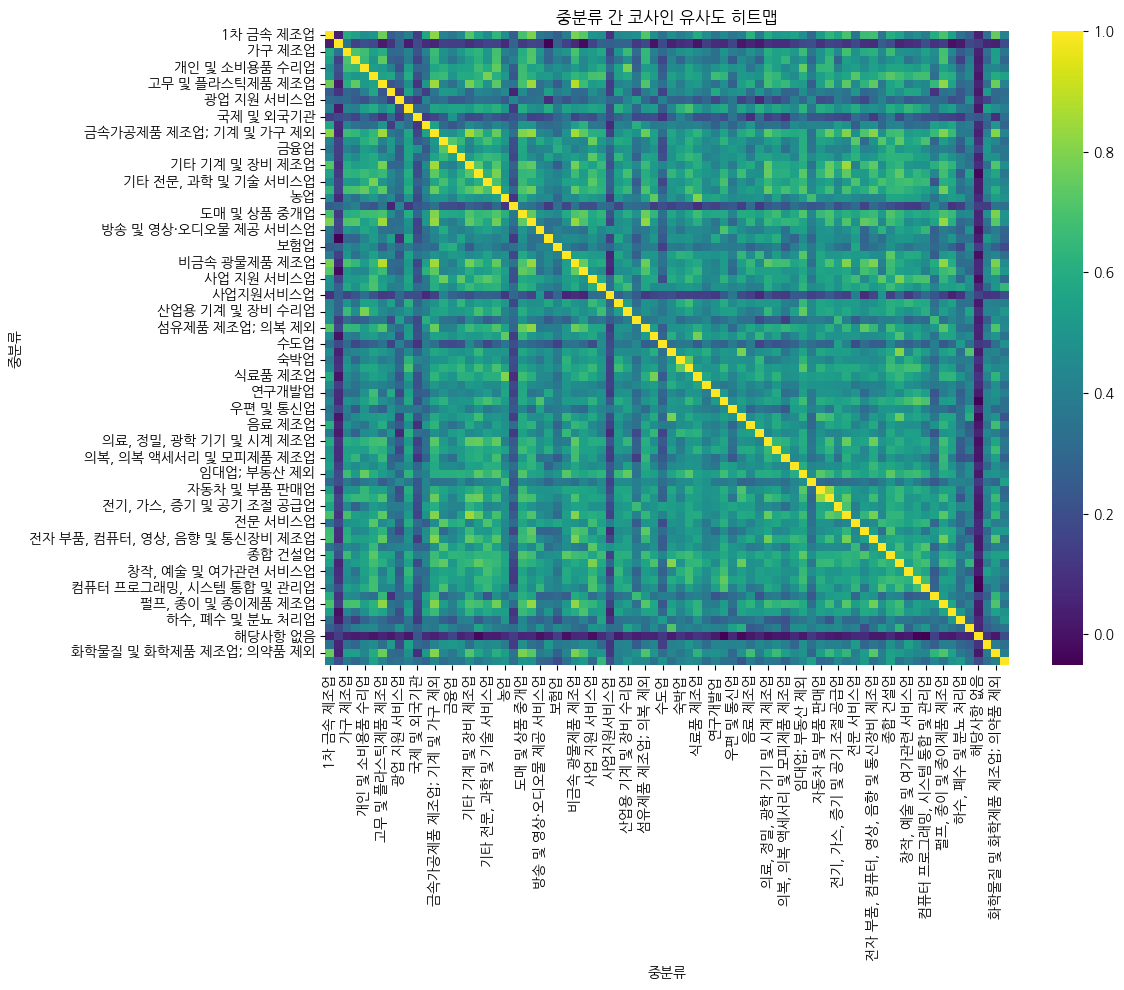

In [ ]:
# 코사인 유사도 히트맵

similarity_matrix = cosine_similarity(embeddings)
sim_df = pd.DataFrame(similarity_matrix, index=grouped['중분류'], columns=grouped['중분류'])

plt.figure(figsize=(12, 10))
sns.heatmap(sim_df, cmap='viridis')
plt.title("중분류 간 코사인 유사도 히트맵")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

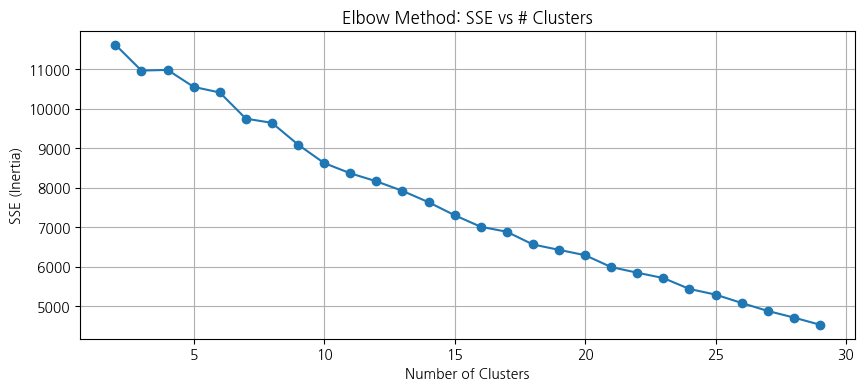

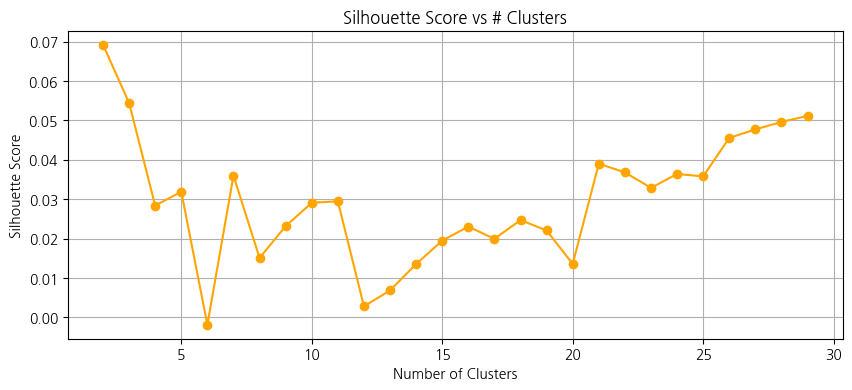

In [ ]:
# 3. Elbow & Silhouette 분석
sse = []
silhouette_scores = []
k_range = range(2, 30)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(embeddings)
    sse.append(km.inertia_)
    silhouette_scores.append(silhouette_score(embeddings, km.labels_))

# 4. Elbow Plot
plt.figure(figsize=(10, 4))
plt.plot(k_range, sse, marker='o')
plt.title("Elbow Method: SSE vs # Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Inertia)")
plt.grid(True)
plt.show()

# 5. Silhouette Score Plot
plt.figure(figsize=(10, 4))
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Score vs # Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

#### 05.13 추가 테스트

In [ ]:
df_code = df[["중분류.2", "중분류.3"]]
df_code.drop_duplicates(inplace=True)
df_code.columns = ["중분류_코드", "중분류"]

result_df = pd.read_csv("/content/drive/MyDrive/업종 클러스터링/강소기업기준_과제_노인일자리_통합.csv", index_col=0)

<ipython-input-17-3de224ff9562>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_code.drop_duplicates(inplace=True)


In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 5)
a

군집 0 : 23개 중분류
군집 1 : 10개 중분류
군집 2 : 5개 중분류
군집 3 : 39개 중분류
군집 4 : 1개 중분류




,군집,강소기업 수,대표키워드
0,0,9033,"제조업, 도매업, 기타, 중개업, 금속, 공사업, 기계, 제품, 처리업, 1차"
1,1,1115,"소매업, 운송업, 기타, 자동차, 화물, 신품, 화물자동차, 판매업, 여객, 중고"
2,2,887,"제조업, 플라스틱, 기타, 의복, 제품, 고무, 플라스틱제품, 고무제품, 겉옷, 가구"
3,3,4313,"기타, 서비스업, 운영업, 제조업, 임대업, 건물, 개발, 비주거용, 행정, 건설업"


In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 6)
a

군집 0 : 18개 중분류
군집 1 : 4개 중분류
군집 2 : 4개 중분류
군집 3 : 28개 중분류
군집 4 : 1개 중분류
군집 5 : 23개 중분류




,군집,강소기업 수,대표키워드
0,0,8422,"제조업, 도매업, 기타, 중개업, 금속, 공사업, 기계, 1차, 제품, 상품"
1,1,835,"운송업, 자동차, 신품, 화물자동차, 판매업, 부품, 개인, 자동차용, 제조업, 화물"
2,2,751,"제조업, 플라스틱, 기타, 의복, 고무, 고무제품, 플라스틱제품, 제품, 겉옷, 액세서리"
3,3,3363,"기타, 제조업, 임대업, 운영업, 개발, 건물, 비주거용, 서비스업, 공급업, 건설업"
4,5,1977,"소매업, 기타, 서비스업, 제조업, 지원, 운영업, 분류, 안된, 행정, 단체"


In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 7)
a

군집 0 : 18개 중분류
군집 1 : 7개 중분류
군집 2 : 4개 중분류
군집 3 : 21개 중분류
군집 4 : 1개 중분류
군집 5 : 18개 중분류
군집 6 : 9개 중분류




,군집,강소기업 수,대표키워드
0,0,8422,"제조업, 도매업, 기타, 중개업, 금속, 공사업, 기계, 1차, 제품, 상품"
1,1,944,"운송업, 자동차, 화물, 신품, 화물자동차, 여객, 판매업, 기타, 부품, 개인"
2,2,751,"제조업, 플라스틱, 기타, 의복, 고무, 고무제품, 플라스틱제품, 겉옷, 제품, 액세서리"
3,3,2304,"기타, 임대업, 운영업, 개발, 건물, 제조업, 비주거용, 건설업, 교육기관, 공급업"
4,5,2151,"서비스업, 기타, 행정, 단체, 제조업, 지원, 운영업, 사업, 연구개발업, 예술가"
5,6,776,"소매업, 기타, 제조업, 가금류, 상품, 곡물, 어업, 재배업, 처리업, 분류"


In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 9)
a

군집 0 : 7개 중분류
군집 1 : 8개 중분류
군집 2 : 3개 중분류
군집 3 : 15개 중분류
군집 4 : 11개 중분류
군집 5 : 1개 중분류
군집 6 : 14개 중분류
군집 7 : 18개 중분류
군집 8 : 1개 중분류




,군집,강소기업 수,대표키워드
0,0,627,"공사업, 광업, 폐기물, 해체, 기타, 금속류, 설치, 지정, 선별업, 전문공사업"
1,1,1145,"운송업, 자동차, 신품, 화물자동차, 화물, 기타, 제조업, 판매업, 임대업, 부품"
2,2,1304,"영화, 소프트웨어, 비디오물, 개발, 제작업, 공급업, 게임, 출판업, 프로그램, 방송업"
3,3,272,"기타, 운영업, 건물, 서비스업, 행정, 임대업, 단체, 교육기관, 비주거용, 주점업"
4,4,842,"서비스업, 기타, 지원, 사업, 금융, 분류, 안된, 중개업, 관련, 금융업"
5,6,2883,"도매업, 소매업, 기타, 중개업, 제조업, 상품, 건설업, 의복, 곡물, 가공식품"
6,7,8275,"제조업, 기타, 제품, 금속, 플라스틱, 유사, 기기, 가공업, 기계, 산업용"


In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 10)
a

군집 0 : 7개 중분류
군집 1 : 8개 중분류
군집 2 : 3개 중분류
군집 3 : 14개 중분류
군집 4 : 11개 중분류
군집 5 : 1개 중분류
군집 6 : 14개 중분류
군집 7 : 18개 중분류
군집 8 : 1개 중분류
군집 9 : 1개 중분류




,군집,강소기업 수,대표키워드
0,0,627,"공사업, 광업, 폐기물, 해체, 기타, 금속류, 설치, 지정, 선별업, 전문공사업"
1,1,1145,"운송업, 자동차, 신품, 화물자동차, 화물, 기타, 제조업, 판매업, 임대업, 부품"
2,2,1304,"영화, 소프트웨어, 비디오물, 개발, 제작업, 공급업, 게임, 출판업, 프로그램, 방송업"
3,3,272,"기타, 운영업, 건물, 서비스업, 행정, 임대업, 단체, 교육기관, 비주거용, 주점업"
4,4,842,"서비스업, 기타, 지원, 사업, 분류, 안된, 금융, 중개업, 관련, 금융업"
5,6,2883,"도매업, 소매업, 기타, 중개업, 제조업, 상품, 건설업, 의복, 곡물, 가공식품"
6,7,8275,"제조업, 기타, 제품, 금속, 플라스틱, 유사, 기기, 가공업, 기계, 산업용"


In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 11)
a

군집 0 : 8개 중분류
군집 1 : 6개 중분류
군집 2 : 3개 중분류
군집 3 : 14개 중분류
군집 4 : 11개 중분류
군집 5 : 1개 중분류
군집 6 : 14개 중분류
군집 7 : 18개 중분류
군집 8 : 1개 중분류
군집 9 : 1개 중분류
군집 10 : 1개 중분류




,군집,강소기업 수,대표키워드
0,0,978,"공사업, 제조업, 광업, 기타, 비철금속, 합금, 제련, 정련, 폐기물, 압연"
1,1,862,"운송업, 자동차, 신품, 화물자동차, 판매업, 임대업, 화물, 기타, 부품, 여객"
2,2,1304,"영화, 소프트웨어, 비디오물, 개발, 제작업, 공급업, 게임, 출판업, 프로그램, 방송업"
3,3,272,"기타, 운영업, 건물, 서비스업, 행정, 임대업, 단체, 교육기관, 비주거용, 주점업"
4,4,938,"서비스업, 기타, 지원, 사업, 분류, 안된, 관련, 금융, 화물, 대리"
5,6,2883,"도매업, 소매업, 기타, 중개업, 제조업, 상품, 건설업, 의복, 곡물, 가공식품"
6,7,8111,"제조업, 기타, 금속, 제품, 플라스틱, 유사, 기기, 가공업, 기계, 산업용"


In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 12)
a

군집 0 : 6개 중분류
군집 1 : 6개 중분류
군집 2 : 3개 중분류
군집 3 : 14개 중분류
군집 4 : 11개 중분류
군집 5 : 1개 중분류
군집 6 : 14개 중분류
군집 7 : 6개 중분류
군집 8 : 1개 중분류
군집 9 : 1개 중분류
군집 10 : 1개 중분류
군집 11 : 14개 중분류




,군집,강소기업 수,대표키워드
0,0,167,"광업, 폐기물, 금속류, 선별업, 지정, 비철금속, 해체, 수집, 채취업, 비금속광물"
1,1,862,"운송업, 자동차, 신품, 화물자동차, 판매업, 임대업, 화물, 부품, 기타, 여객"
2,2,1304,"영화, 소프트웨어, 비디오물, 개발, 제작업, 공급업, 게임, 출판업, 프로그램, 방송업"
3,3,272,"기타, 운영업, 건물, 서비스업, 행정, 임대업, 단체, 교육기관, 비주거용, 주점업"
4,4,938,"서비스업, 기타, 지원, 사업, 분류, 안된, 관련, 금융, 화물, 중개업"
5,6,2883,"도매업, 소매업, 기타, 중개업, 제조업, 상품, 건설업, 가공식품, 곡물, 수리업"
6,7,4785,"제조업, 기타, 기계, 기기, 건조업, 전기, 인쇄업, 전자, 산업용, 장치"
7,11,4137,"제조업, 기타, 공사업, 제품, 금속, 플라스틱, 유사, 가공업, 콘크리트, 방적업"


In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 13)
a

군집 0 : 6개 중분류
군집 1 : 5개 중분류
군집 2 : 3개 중분류
군집 3 : 13개 중분류
군집 4 : 11개 중분류
군집 5 : 1개 중분류
군집 6 : 8개 중분류
군집 7 : 6개 중분류
군집 8 : 1개 중분류
군집 9 : 1개 중분류
군집 10 : 1개 중분류
군집 11 : 14개 중분류
군집 12 : 8개 중분류




,군집,강소기업 수,대표키워드
0,0,167,"광업, 폐기물, 금속류, 선별업, 지정, 비철금속, 해체, 수집, 채취업, 비금속광물"
1,1,850,"운송업, 자동차, 신품, 화물자동차, 판매업, 임대업, 부품, 개인, 자동차용, 기타"
2,2,1304,"영화, 소프트웨어, 개발, 제작업, 공급업, 비디오물, 게임, 출판업, 프로그램, 방송업"
3,3,244,"기타, 운영업, 건물, 서비스업, 행정, 임대업, 교육기관, 단체, 비주거용, 부동산"
4,4,938,"서비스업, 기타, 지원, 사업, 분류, 안된, 금융, 관련, 화물, 대리"
5,6,2114,"도매업, 중개업, 기타, 건설업, 상품, 수리업, 기계, 1차, 생활용, 장비"
6,7,4785,"제조업, 기타, 기계, 기기, 건조업, 전기, 인쇄업, 전자, 산업용, 장치"
7,11,4137,"제조업, 기타, 공사업, 금속, 제품, 플라스틱, 유사, 가공업, 정련, 합금"
8,12,809,"소매업, 기타, 제조업, 주점업, 상품, 가금류, 음식점업, 전문점, 처리업, 안된"


In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 14)
a

군집 0 : 6개 중분류
군집 1 : 5개 중분류
군집 2 : 3개 중분류
군집 3 : 13개 중분류
군집 4 : 10개 중분류
군집 5 : 1개 중분류
군집 6 : 8개 중분류
군집 7 : 6개 중분류
군집 8 : 1개 중분류
군집 9 : 1개 중분류
군집 10 : 1개 중분류
군집 11 : 14개 중분류
군집 12 : 7개 중분류
군집 13 : 2개 중분류




,군집,강소기업 수,대표키워드
0,0,167,"광업, 폐기물, 금속류, 선별업, 지정, 비철금속, 해체, 수집, 채취업, 비금속광물"
1,1,850,"운송업, 자동차, 신품, 화물자동차, 판매업, 임대업, 부품, 개인, 자동차용, 제조업"
2,2,1304,"영화, 소프트웨어, 개발, 공급업, 비디오물, 제작업, 게임, 출판업, 프로그램, 방송업"
3,3,244,"운영업, 기타, 건물, 서비스업, 행정, 임대업, 교육기관, 단체, 비주거용, 부동산"
4,4,937,"서비스업, 기타, 지원, 사업, 분류, 안된, 관련, 금융, 대리, 화물"
5,6,2114,"도매업, 중개업, 기타, 건설업, 상품, 수리업, 기계, 1차, 생활용, 장비"
6,7,4785,"제조업, 기타, 기계, 기기, 건조업, 전기, 인쇄업, 전자, 산업용, 장치"
7,11,4137,"제조업, 기타, 공사업, 금속, 제품, 플라스틱, 유사, 가공업, 제련, 정련"
8,12,797,"소매업, 기타, 제조업, 주점업, 상품, 가금류, 전문점, 음식점업, 안된, 분류"
9,13,13,"운송업, 여객, 화물, 내항, 외항, 내륙, 항공, 수상, 기타, 항만"


In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 15)
a

군집 0 : 6개 중분류
군집 1 : 5개 중분류
군집 2 : 3개 중분류
군집 3 : 12개 중분류
군집 4 : 10개 중분류
군집 5 : 1개 중분류
군집 6 : 7개 중분류
군집 7 : 6개 중분류
군집 8 : 1개 중분류
군집 9 : 1개 중분류
군집 10 : 1개 중분류
군집 11 : 14개 중분류
군집 12 : 7개 중분류
군집 13 : 2개 중분류
군집 14 : 2개 중분류




,군집,강소기업 수,대표키워드
0,0,167,"광업, 폐기물, 금속류, 선별업, 지정, 비철금속, 해체, 수집, 채취업, 비금속광물"
1,1,850,"운송업, 자동차, 신품, 화물자동차, 판매업, 임대업, 부품, 개인, 제조업, 자동차용"
2,2,1304,"영화, 소프트웨어, 개발, 비디오물, 제작업, 공급업, 게임, 출판업, 프로그램, 방송업"
3,3,218,"운영업, 기타, 건물, 행정, 임대업, 단체, 교육기관, 비주거용, 부동산, 주거용"
4,4,937,"서비스업, 기타, 지원, 사업, 분류, 안된, 관련, 금융, 대리, 화물"
5,6,2114,"도매업, 중개업, 기타, 건설업, 상품, 수리업, 기계, 1차, 생활용, 장비"
6,7,4785,"제조업, 기타, 기계, 기기, 건조업, 전기, 인쇄업, 전자, 산업용, 장치"
7,11,4137,"제조업, 기타, 공사업, 금속, 제품, 플라스틱, 유사, 가공업, 정련, 합금"
8,12,817,"소매업, 기타, 제조업, 서비스업, 주점업, 상품, 가금류, 음식점업, 전문점, 안된"
9,13,13,"운송업, 여객, 화물, 내항, 외항, 내륙, 항공, 수상, 기타, 항만"


In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 16)
a

군집 0 : 6개 중분류
군집 1 : 5개 중분류
군집 2 : 3개 중분류
군집 3 : 12개 중분류
군집 4 : 9개 중분류
군집 5 : 1개 중분류
군집 6 : 7개 중분류
군집 7 : 6개 중분류
군집 8 : 1개 중분류
군집 9 : 1개 중분류
군집 10 : 1개 중분류
군집 11 : 14개 중분류
군집 12 : 7개 중분류
군집 13 : 2개 중분류
군집 14 : 2개 중분류
군집 15 : 1개 중분류




,군집,강소기업 수,대표키워드
0,0,167,"광업, 폐기물, 금속류, 선별업, 지정, 비철금속, 해체, 수집, 채취업, 비금속광물"
1,1,850,"운송업, 자동차, 신품, 화물자동차, 판매업, 임대업, 부품, 개인, 제조업, 자동차용"
2,2,1304,"영화, 소프트웨어, 개발, 비디오물, 제작업, 공급업, 게임, 출판업, 프로그램, 방송업"
3,3,218,"운영업, 기타, 건물, 행정, 임대업, 단체, 교육기관, 비주거용, 부동산, 주거용"
4,4,820,"서비스업, 기타, 지원, 사업, 분류, 안된, 관련, 금융, 대리, 화물"
5,6,2114,"도매업, 중개업, 기타, 건설업, 상품, 수리업, 기계, 1차, 생활용, 장비"
6,7,4785,"제조업, 기타, 기계, 기기, 건조업, 전기, 인쇄업, 전자, 산업용, 장치"
7,11,4137,"제조업, 기타, 공사업, 금속, 제품, 플라스틱, 유사, 가공업, 콘크리트, 방적업"
8,12,817,"소매업, 기타, 제조업, 서비스업, 주점업, 상품, 가금류, 음식점업, 전문점, 안된"
9,13,13,"운송업, 여객, 화물, 내항, 외항, 내륙, 항공, 수상, 기타, 항만"


In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 17)
a

군집 0 : 6개 중분류
군집 1 : 4개 중분류
군집 2 : 3개 중분류
군집 3 : 12개 중분류
군집 4 : 9개 중분류
군집 5 : 1개 중분류
군집 6 : 6개 중분류
군집 7 : 5개 중분류
군집 8 : 1개 중분류
군집 9 : 1개 중분류
군집 10 : 1개 중분류
군집 11 : 4개 중분류
군집 12 : 7개 중분류
군집 13 : 2개 중분류
군집 14 : 2개 중분류
군집 15 : 1개 중분류
군집 16 : 13개 중분류




,군집,강소기업 수,대표키워드
0,0,158,"광업, 폐기물, 발전업, 지정, 금속류, 선별업, 비철금속, 수집, 채취업, 비금속광물"
1,1,840,"운송업, 자동차, 신품, 화물자동차, 임대업, 판매업, 부품, 개인, 제조업, 자동차용"
2,2,1304,"영화, 소프트웨어, 개발, 비디오물, 제작업, 공급업, 게임, 출판업, 프로그램, 방송업"
3,3,218,"운영업, 기타, 건물, 행정, 임대업, 단체, 교육기관, 비주거용, 부동산, 주거용"
4,4,820,"서비스업, 기타, 지원, 사업, 분류, 안된, 금융, 관련, 대리, 화물"
5,6,1976,"도매업, 중개업, 기타, 건설업, 상품, 수리업, 기계, 1차, 생활용, 장비"
6,7,2170,"제조업, 기타, 기기, 건조업, 전자, 인쇄업, 선박, 차량, 측정, 악기"
7,11,794,"공사업, 제조업, 기타, 방적업, 가공업, 직조업, 목재, 직물, 설치, 전문공사업"
8,12,817,"소매업, 기타, 제조업, 서비스업, 주점업, 상품, 가금류, 전문점, 음식점업, 곡물"
9,13,13,"운송업, 여객, 화물, 내항, 외항, 내륙, 항공, 수상, 기타, 항만"


In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 18)
a

군집 0 : 6개 중분류
군집 1 : 4개 중분류
군집 2 : 3개 중분류
군집 3 : 12개 중분류
군집 4 : 9개 중분류
군집 5 : 1개 중분류
군집 6 : 6개 중분류
군집 7 : 5개 중분류
군집 8 : 1개 중분류
군집 9 : 1개 중분류
군집 10 : 1개 중분류
군집 11 : 4개 중분류
군집 12 : 6개 중분류
군집 13 : 2개 중분류
군집 14 : 2개 중분류
군집 15 : 1개 중분류
군집 16 : 13개 중분류
군집 17 : 1개 중분류




,군집,강소기업 수,대표키워드
0,0,158,"광업, 폐기물, 발전업, 지정, 금속류, 선별업, 비철금속, 수집, 채취업, 비금속광물"
1,1,840,"운송업, 자동차, 신품, 화물자동차, 임대업, 판매업, 부품, 개인, 제조업, 자동차용"
2,2,1304,"영화, 소프트웨어, 개발, 공급업, 비디오물, 제작업, 게임, 출판업, 프로그램, 방송업"
3,3,244,"운영업, 기타, 건물, 서비스업, 행정, 임대업, 단체, 교육기관, 비주거용, 부동산"
4,4,820,"서비스업, 기타, 지원, 사업, 분류, 안된, 금융, 관련, 대리, 화물"
5,6,1976,"도매업, 중개업, 기타, 건설업, 상품, 수리업, 기계, 1차, 생활용, 장비"
6,7,2170,"제조업, 기타, 기기, 건조업, 전자, 인쇄업, 선박, 차량, 측정, 악기"
7,11,794,"공사업, 제조업, 기타, 방적업, 가공업, 직조업, 목재, 직물, 설치, 전문공사업"
8,12,791,"소매업, 기타, 제조업, 주점업, 상품, 음식점업, 가금류, 전문점, 곡물, 안된"
9,13,13,"운송업, 여객, 화물, 내항, 외항, 내륙, 항공, 수상, 기타, 항만"


In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 19)

군집 0 : 4개 중분류
군집 1 : 4개 중분류
군집 2 : 3개 중분류
군집 3 : 10개 중분류
군집 4 : 9개 중분류
군집 5 : 1개 중분류
군집 6 : 6개 중분류
군집 7 : 4개 중분류
군집 8 : 1개 중분류
군집 9 : 1개 중분류
군집 10 : 1개 중분류
군집 11 : 4개 중분류
군집 12 : 7개 중분류
군집 13 : 2개 중분류
군집 14 : 1개 중분류
군집 15 : 1개 중분류
군집 16 : 14개 중분류
군집 17 : 1개 중분류
군집 18 : 4개 중분류




In [ ]:
a.to_excel("/content/drive/MyDrive/업종 클러스터링/k19_핵심키워드.xlsx")

In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 20)
a

군집 0 : 4개 중분류
군집 1 : 3개 중분류
군집 2 : 3개 중분류
군집 3 : 7개 중분류
군집 4 : 9개 중분류
군집 5 : 1개 중분류
군집 6 : 2개 중분류
군집 7 : 3개 중분류
군집 8 : 1개 중분류
군집 9 : 1개 중분류
군집 10 : 1개 중분류
군집 11 : 4개 중분류
군집 12 : 7개 중분류
군집 13 : 2개 중분류
군집 14 : 1개 중분류
군집 15 : 1개 중분류
군집 16 : 14개 중분류
군집 17 : 1개 중분류
군집 18 : 4개 중분류
군집 19 : 9개 중분류




,군집,강소기업 수,대표키워드
0,0,148,"광업, 폐기물, 지정, 선별업, 금속류, 해체, 수집, 비철금속, 채취업, 비금속광물"
1,1,825,"운송업, 자동차, 신품, 화물자동차, 판매업, 부품, 제조업, 자동차용, 화물, 개인"
2,2,1304,"영화, 소프트웨어, 개발, 공급업, 비디오물, 제작업, 게임, 출판업, 프로그램, 방송업"
3,3,172,"기타, 행정, 교육기관, 단체, 운영업, 예술가, 일반의원, 연구개발업, 의료업, 공연"
4,4,820,"서비스업, 기타, 지원, 사업, 분류, 안된, 관련, 금융, 대리, 화물"
5,6,1704,"도매업, 중개업, 기타, 상품, 1차, 생활용, 섬유, 기계, 장비, 건축자재"
6,7,1843,"제조업, 기타, 기기, 인쇄업, 측정, 전자, 표시장치, 광학, 기구, 부품"
7,11,794,"공사업, 제조업, 기타, 방적업, 가공업, 직조업, 목재, 직물, 제품, 설치"
8,12,817,"소매업, 기타, 제조업, 서비스업, 주점업, 상품, 가금류, 음식점업, 전문점, 곡물"
9,13,13,"운송업, 여객, 화물, 내항, 외항, 내륙, 항공, 수상, 기타, 항만"


#### Okt -> 명사만 추출한 뒤 임베딩

In [ ]:
# 1. 중분류별 세세분류 통합
df_2 = df[['중분류.3', '세세분류.1']].dropna()
grouped_2 = df_2.groupby('중분류.3')['세세분류.1'].apply(lambda x: ' '.join(x)).reset_index()
grouped_2.columns = ['중분류', '세세분류_통합']

# 텍스트 전처리
grouped_2['세세분류_통합'] = grouped_2['세세분류_통합'].apply(clean_text)

In [ ]:
# 5. 임베딩 수행
embeddings2 = model.encode(grouped_2['세세분류_통합'], show_progress_bar=True)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

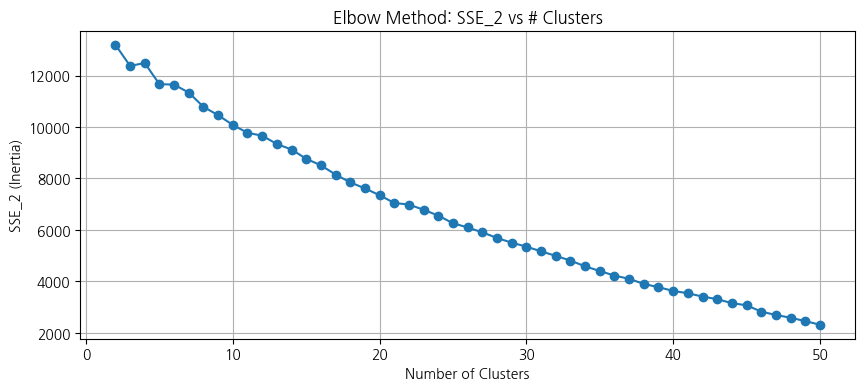

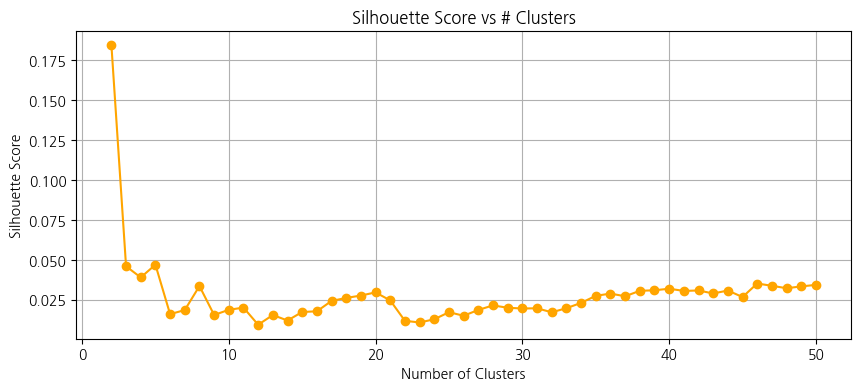

In [ ]:
# 3. Elbow & Silhouette 분석
sse_2 = []
silhouette_scores_2 = []
k_range = range(2, 51)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(embeddings2)
    sse_2.append(km.inertia_)
    silhouette_scores_2.append(silhouette_score(embeddings2, km.labels_))

# 4. Elbow Plot
plt.figure(figsize=(10, 4))
plt.plot(k_range, sse_2, marker='o')
plt.title("Elbow Method: SSE_2 vs # Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE_2 (Inertia)")
plt.grid(True)
plt.show()

# 5. Silhouette Score Plot
plt.figure(figsize=(10, 4))
plt.plot(k_range, silhouette_scores_2, marker='o', color='orange')
plt.title("Silhouette Score vs # Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

##### 클러스터 수 늘리기

In [ ]:
df_code = df[["중분류.2", "중분류.3"]]
df_code.drop_duplicates(inplace=True)
df_code.columns = ["중분류_코드", "중분류"]

result_df = pd.read_csv("/content/drive/MyDrive/업종 클러스터링/강소기업기준_과제_노인일자리_통합.csv", index_col=0)

In [ ]:
result_df = pd.read_csv("/content/drive/MyDrive/업종 클러스터링/강소기업기준_과제_노인일자리_통합.csv", index_col=0)

In [ ]:
# 29개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 29)
a

군집 0 : 2개 중분류
군집 1 : 2개 중분류
군집 2 : 3개 중분류
군집 3 : 4개 중분류
군집 4 : 1개 중분류
군집 5 : 3개 중분류
군집 6 : 15개 중분류
군집 7 : 1개 중분류
군집 8 : 1개 중분류
군집 9 : 1개 중분류
군집 10 : 6개 중분류
군집 11 : 1개 중분류
군집 12 : 2개 중분류
군집 13 : 4개 중분류
군집 14 : 2개 중분류
군집 15 : 1개 중분류
군집 16 : 1개 중분류
군집 17 : 1개 중분류
군집 18 : 4개 중분류
군집 19 : 3개 중분류
군집 20 : 1개 중분류
군집 21 : 1개 중분류
군집 22 : 3개 중분류
군집 23 : 1개 중분류
군집 24 : 2개 중분류
군집 25 : 9개 중분류
군집 26 : 1개 중분류
군집 27 : 1개 중분류
군집 28 : 1개 중분류




,군집,강소기업 수,대표키워드
0,0,141,"폐기물, 광업, 선별업, 지정, 금속류, 비금속광물, 채취업, 수집, 해체, 채굴"
1,1,764,"신품, 자동차, 판매업, 부품, 제조업, 자동차용, 중고, 내장품, 전기, 내장용"
2,2,1304,"영화, 소프트웨어, 개발, 비디오물, 공급업, 제작업, 게임, 출판업, 프로그램, 방송업"
3,3,68,"행정, 교육기관, 기타, 운영업, 예술가, 교과학원, 공연, 직업, 복지시설, 일반"
4,5,1843,"제조업, 기기, 기타, 인쇄업, 측정, 전자, 표시장치, 광학, 기구, 부품"
5,6,7876,"제조업, 도매업, 기타, 중개업, 금속, 공사업, 제품, 기계, 플라스틱, 1차"
6,8,117,"콜센터, 텔레마케팅, 서비스업, 산화물, 산업재해, 산업용수, 산업용, 산업설비, ..."
7,10,675,"서비스업, 기타, 지원, 사업, 금융, 분류, 안된, 관련, 금융업, 정보"
8,11,6,"처리업, 하수, 분뇨, 사람, 축산, 산업용수, 산업용, 산업설비, 산업재해, 살균..."
9,12,136,"청소업, 서비스업, 유지ㆍ관리, 복원업, 소독, 사업시설, 산업설비, 유지, 환경,..."


In [ ]:
# 21개 - Okt 적용 x

a = merge_print_result(grouped, result_df, df_code, embeddings, 20)
a

군집 0 : 4개 중분류
군집 1 : 3개 중분류
군집 2 : 3개 중분류
군집 3 : 7개 중분류
군집 4 : 9개 중분류
군집 5 : 1개 중분류
군집 6 : 2개 중분류
군집 7 : 3개 중분류
군집 8 : 1개 중분류
군집 9 : 1개 중분류
군집 10 : 1개 중분류
군집 11 : 4개 중분류
군집 12 : 7개 중분류
군집 13 : 2개 중분류
군집 14 : 1개 중분류
군집 15 : 1개 중분류
군집 16 : 14개 중분류
군집 17 : 1개 중분류
군집 18 : 4개 중분류
군집 19 : 9개 중분류




,군집,강소기업 수,대표키워드
0,0,148,"광업, 폐기물, 지정, 선별업, 금속류, 해체, 수집, 비철금속, 채취업, 비금속광물"
1,1,825,"운송업, 자동차, 신품, 화물자동차, 판매업, 부품, 제조업, 자동차용, 화물, 개인"
2,2,1304,"영화, 소프트웨어, 개발, 공급업, 비디오물, 제작업, 게임, 출판업, 프로그램, 방송업"
3,3,172,"기타, 행정, 교육기관, 단체, 운영업, 예술가, 일반의원, 연구개발업, 의료업, 공연"
4,4,820,"서비스업, 기타, 지원, 사업, 분류, 안된, 관련, 금융, 대리, 화물"
5,6,1704,"도매업, 중개업, 기타, 상품, 1차, 생활용, 섬유, 기계, 장비, 건축자재"
6,7,1843,"제조업, 기타, 기기, 인쇄업, 측정, 전자, 표시장치, 광학, 기구, 부품"
7,11,794,"공사업, 제조업, 기타, 방적업, 가공업, 직조업, 목재, 직물, 제품, 설치"
8,12,817,"소매업, 기타, 제조업, 서비스업, 주점업, 상품, 가금류, 음식점업, 전문점, 곡물"
9,13,13,"운송업, 여객, 화물, 내항, 외항, 내륙, 항공, 수상, 기타, 항만"


In [ ]:
# 21개 - Okt 적용 o

a = merge_print_result(grouped_2, result_df, df_code, embeddings2, 20)
a

군집 0 : 2개 중분류
군집 1 : 1개 중분류
군집 2 : 5개 중분류
군집 3 : 3개 중분류
군집 4 : 15개 중분류
군집 5 : 2개 중분류
군집 6 : 11개 중분류
군집 7 : 1개 중분류
군집 8 : 3개 중분류
군집 9 : 1개 중분류
군집 10 : 1개 중분류
군집 11 : 11개 중분류
군집 12 : 5개 중분류
군집 13 : 2개 중분류
군집 14 : 3개 중분류
군집 15 : 1개 중분류
군집 16 : 7개 중분류
군집 17 : 1개 중분류
군집 18 : 2개 중분류
군집 19 : 1개 중분류




,군집,강소기업 수,대표키워드
0,0,6,"광업, 광물, 비금속, 비철금속, 취업, 모래, 쇄석, 자갈, 석재, 생산"
1,1,8,"통신업, 재판매, 우편, 위성, 무선, 유선, 통신, 전기, 기타, 보조"
2,2,195,"운송업, 화물, 자동차, 화물자동차, 판매업, 신품, 여객, 개인, 기타, 일반"
3,3,849,"제조업, 기초, 기타, 제품, 물질, 화학, 살충제, 살균, 의약품, 관련"
4,4,9007,"제조업, 도매, 제품, 기타, 금속, 중개업, 기계, 장비, 사업, 장치"
5,5,42,"영화, 비디오, 작업, 프로그램, 방송업, 제공, 오물, 오디, 애니메이션, 방송"
6,6,1472,"영업, 학원, 기타, 교육, 개발, 단체, 건물, 행정, 임대, 기관"
7,8,174,"제조업, 가구, 기타, 목재, 신발, 가죽, 지갑, 매트리스, 부분품, 주방"
8,10,117,"마케팅, 텔레, 콜센터, 서비스업, 복용, 복권, 보호, 보험, 복원, 복지"
9,11,1489,"제조업, 기타, 건설업, 임대, 수리, 달리, 장비, 개인, 서비스업, 의복"


In [ ]:
kmeans = KMeans(n_clusters=20, random_state=42)
grouped['군집'] = kmeans.fit_predict(embeddings)

cluster_result = pd.merge(grouped, df_code, on="중분류")
cluster_result.to_csv("/content/drive/MyDrive/업종 클러스터링/k20_중분류_군집화.csv", index=False)
a.to_csv("/content/drive/MyDrive/업종 클러스터링/k20_핵심키워드.csv", index=False)

In [ ]:
cluster_result

,중분류,세세분류_통합,군집,중분류_코드
0,1차 금속 제조업,제철업 제강업 합금철 제조업 기타 제철 및 제강업 그 외 기타 1차 철강 제조업 주...,16,24.0
1,가구 내 고용활동,가구 내 고용활동,8,97.0
2,가구 제조업,금속 가구 제조업 기타 목재 가구 제조업 그 외 기타 가구 제조업 매트리스 및 침대...,16,32.0
3,"가죽, 가방 및 신발 제조업",모피 및 가죽 제조업 가방 및 기타 보호용 케이스 제조업 기타 가죽제품 제조업 핸드...,11,15.0
4,개인 및 소비용품 수리업,컴퓨터 및 주변 기기 수리업 그 외 기타 개인 및 가정용품 수리업 가전제품 수리업 ...,19,95.0
...,...,...,...,...
73,항공 운송업,항공 여객 운송업 항공 화물 운송업,13,51.0
74,해당사항 없음,해당사항 없음,9,NaN
75,협회 및 단체,산업 단체 전문가 단체 노동조합 불교 단체 기독교 단체 천주교 단체 민족 종교 단체...,3,94.0
76,화학물질 및 화학제품 제조업; 의약품 제외,"기타 기초 무기화학 물질 제조업 수소 제조업 산소, 질소 및 기타 산업용 가스 제조...",16,20.0
